<a href="https://colab.research.google.com/github/JMan003/ML-Project/blob/main/MT2025056_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===========================
# Install libraries
# ===========================
!pip -q install xgboost scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  # Allowed "Part 1" model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from scipy.stats import randint, uniform


In [2]:
from google.colab import files
files.upload()   # upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"johnjoset","key":"1571e996be04eb9db9075205895038fd"}'}

In [3]:
#Move json to right place
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c ait-511-course-project-1-obesity-risk

  0% 0.00/570k [00:00<?, ?B/s]
100% 570k/570k [00:00<00:00, 145MB/s]


In [5]:
!unzip *.zip

Archive:  ait-511-course-project-1-obesity-risk.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [6]:
# ===========================
# 1. Load the data
# ===========================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
original = pd.read_csv("ObesityDataSet.csv")
original = original.rename(columns = {'NObeyesdad' : 'WeightCategory'})
train = pd.concat([train, original], ignore_index=True)

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Sample submission shape:", sample_submission.shape)

Train shape: (17644, 18)
Test shape: (5225, 17)
Sample submission shape: (13840, 2)


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


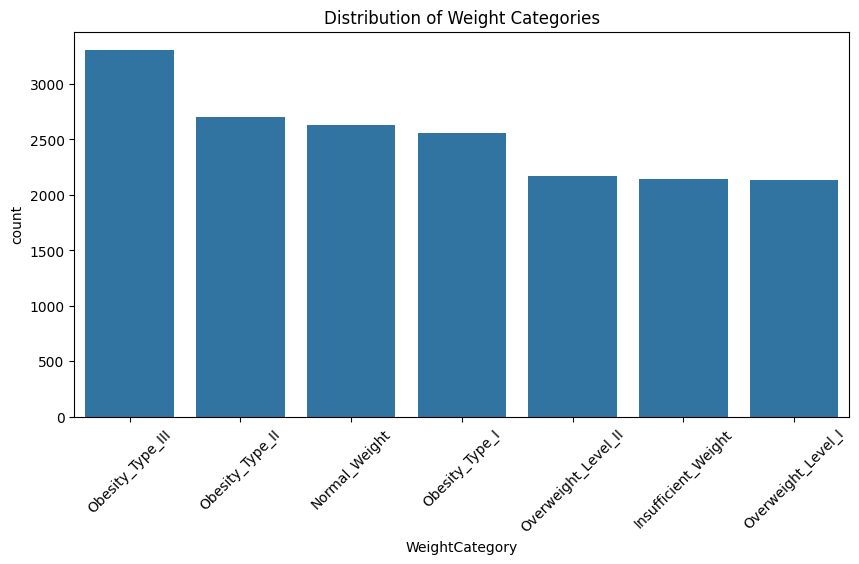

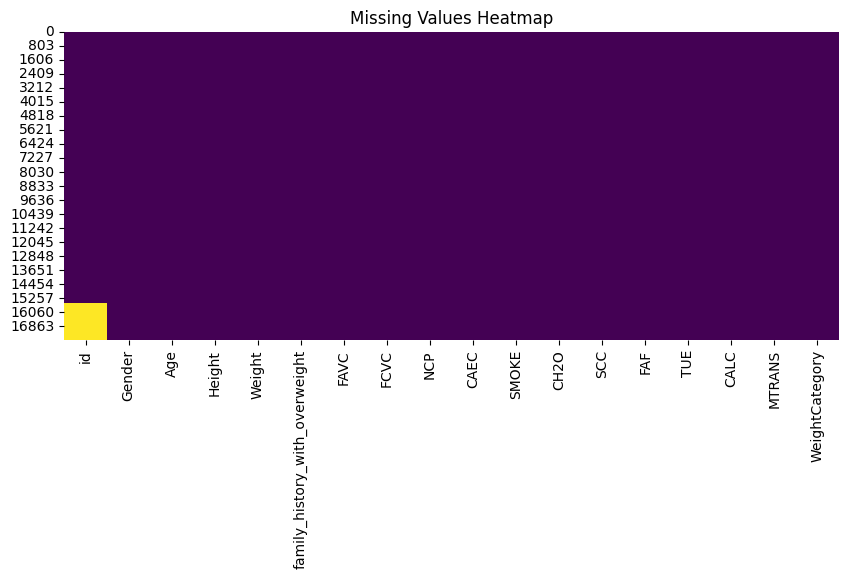

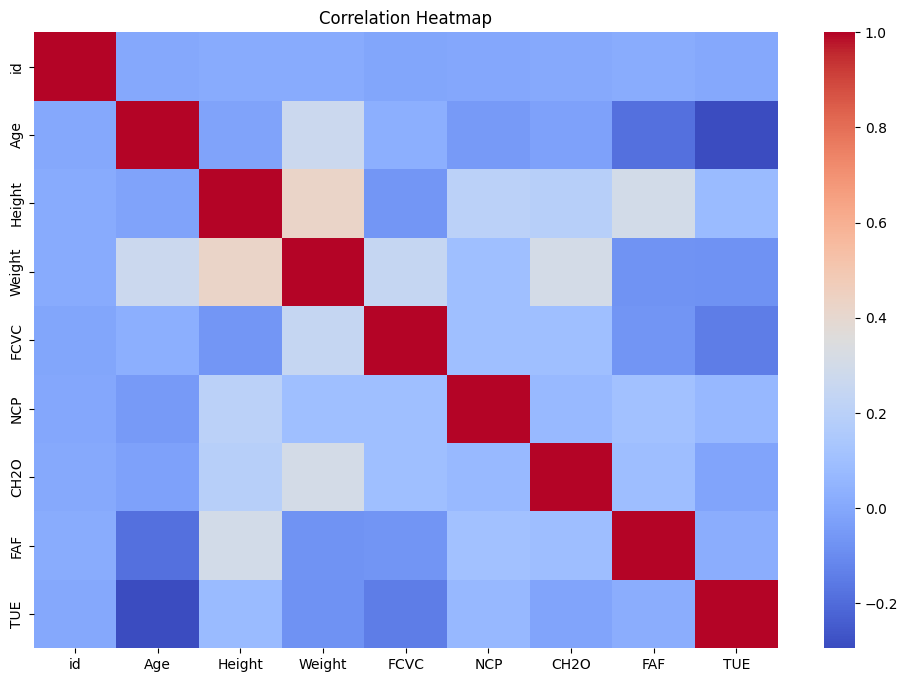

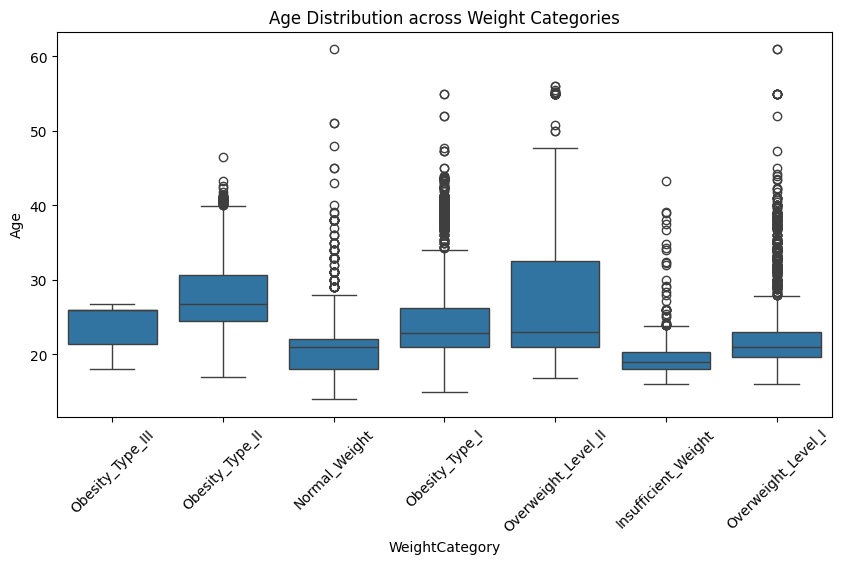

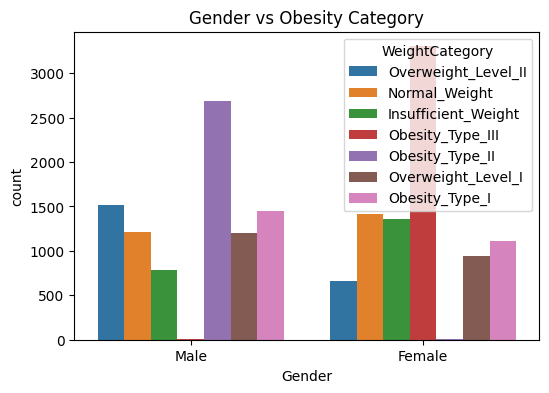

In [7]:
# ===========================
# 2. Exploratory Data Analysis
# ===========================

# Preview
display(train.head())

# Target distribution
plt.figure(figsize=(10,5))
sns.countplot(data=train, x="WeightCategory", order=train["WeightCategory"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Weight Categories")
plt.show()

# Check missing values
plt.figure(figsize=(10,4))
sns.heatmap(train.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# Correlation heatmap (numeric only)
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# Example: Age vs Obesity level
plt.figure(figsize=(10,5))
sns.boxplot(data=train, x="WeightCategory", y="Age", order=train["WeightCategory"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Age Distribution across Weight Categories")
plt.show()

# Example: Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="Gender", hue="WeightCategory")
plt.title("Gender vs Obesity Category")
plt.show()

In [8]:
# ===========================
# 3. Preprocessing
# ===========================


# --- 3.1. Feature Engineering ---
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height']**2 + 1e-6)
    df['BMI^3'] = df['BMI'] ** 3

# --- 3.2. Separate Features and Target ---
X = train.drop(columns=["WeightCategory", "id"])
y = train["WeightCategory"]
X_test = test.drop(columns=["id"])

# --- 3.3. Encode Target ---
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# --- 3.4. Define Features ---
numeric_features = [
    'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
    'BMI', 'BMI^3'
]
nominal_features = ['Gender', 'family_history_with_overweight', 'FAVC','SCC', 'MTRANS']
ordinal_features = ['CAEC', 'CALC']

caec_order = ['no', 'Sometimes', 'Frequently', 'Always']
calc_order = ['no', 'Sometimes', 'Frequently', 'Always']

# --- 3.5. Pipelines ---
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

nominal_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(
        categories=[caec_order, calc_order],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# --- 3.6. Combine ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)
    ],
    remainder='drop'
)

# --- 3.7. Apply ---
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

In [ ]:
# ===========================
# 4. Train model
# ===========================

print("\n--- Executing Step 4: Model Training & Comparison ---")

# --- 4.1. Train-validation split ---
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print(f"Train/Validation split complete. X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

# --- 4.2. Model 1: Logistic Regression ---
print("\nTraining Logistic Regression...")
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
val_preds_log_reg = log_reg.predict(X_val)
print("\n--- Logistic Regression Results ---")
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds_log_reg):.4f}")
print(classification_report(y_val, val_preds_log_reg, target_names=le_target.classes_))

# --- 4.3. Model 2: Decision Tree Classifier ---
print("\nTraining Decision Tree...")
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
val_preds_tree = tree_model.predict(X_val)
print("\n--- Decision Tree Results ---")
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds_tree):.4f}")
print(classification_report(y_val, val_preds_tree, target_names=le_target.classes_))

best_params = {
    'n_estimators': 500,           # Number of trees
    'max_depth': 30,             # Max depth of each tree
    'min_samples_split': 5,           # Min samples to split a node
    'min_samples_leaf': 2,             # Min samples at each leaf node
    'max_features': 'sqrt'      # Number of features to consider
}

# --- 4.3. Set up RandomizedSearchCV ---
# n_iter=50 means it will try 50 different random combinations.
# cv=5 means 5-fold cross-validation.
# n_jobs=-1 uses all your CPU cores to speed it up.
#rf_random_search = RandomizedSearchCV(
#   estimator=RandomForestClassifier(random_state=42, class_weight="balanced"),
#    param_distributions=param_grid,
#    n_iter=50,  # You can increase this for a more thorough search
#    cv=5,
#    verbose=2,
#    random_state=42,
#    n_jobs=-1
#)

# --- 4.4. Fit the search to find the best model ---
#print("Starting Hyperparameter Tuning...")
#rf_random_search.fit(X_train, y_train)

# --- 4.5. Get the Best Model and Evaluate ---
#print("\n--- Tuning Complete ---")
#print(f"Best Parameters Found: {rf_random_search.best_params_}")

# Get the best model found by the search
best_rf_model = RandomForestClassifier(**best_params)

best_rf_model.fit(X_train, y_train)

# Evaluate it on your validation set
val_preds_best_rf = best_rf_model.predict(X_val)

print("\n--- Tuned Random Forest Results ---")
print(f"Validation Accuracy: {accuracy_score(y_val, val_preds_best_rf):.4f}")
print(classification_report(y_val, val_preds_best_rf, target_names=le_target.classes_))

# --- 4.6. XGBoost ---

xgb_final = XGBClassifier(
    subsample=0.7,
    reg_lambda=2.0,
    reg_alpha=0.2222222222222222,
    n_estimators=950,
    min_child_weight=2,
    max_depth=4,
    learning_rate=0.08,
    gamma=1.0,
    colsample_bytree=0.5,
    objective='multi:softmax',     # or 'multi:softprob' if you want probabilities
    num_class=len(np.unique(y_train)),  # Adjust automatically to your data
    random_state=42,
    use_label_encoder=False
)

# Train the model
xgb_final.fit(X_train, y_train)

# Predict on validation or test set
y_pred = xgb_final.predict(X_val)

# Evaluate accuracy
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")


# --- 4.7. Model Comparison Summary ---
print("\n--- Model Comparison Summary ---")
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, val_preds_log_reg):.4f}")
print(f"Decision Tree Accuracy:       {accuracy_score(y_val, val_preds_tree):.4f}")
print(f"Random Forest Accuracy:     {accuracy_score(y_val, val_preds_best_rf):.4f}")
print(f"XGBoost Accuracy:           {acc:.4f}")



--- Executing Step 4: Model Training & Comparison ---
Train/Validation split complete. X_train shape: (14115, 21), X_val shape: (3529, 21)

Training Logistic Regression...

--- Logistic Regression Results ---
Validation Accuracy: 0.8646
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.95      0.91       428
      Normal_Weight       0.86      0.82      0.84       526
     Obesity_Type_I       0.85      0.83      0.84       512
    Obesity_Type_II       0.93      0.97      0.95       540
   Obesity_Type_III       0.99      1.00      0.99       662
 Overweight_Level_I       0.74      0.71      0.72       427
Overweight_Level_II       0.71      0.70      0.71       434

           accuracy                           0.86      3529
          macro avg       0.85      0.85      0.85      3529
       weighted avg       0.86      0.86      0.86      3529


Training Decision Tree...

--- Decision Tree Results ---
Validation Accuracy: 0.8509
  

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.9173

--- Model Comparison Summary ---
Logistic Regression Accuracy: 0.8646
Decision Tree Accuracy:       0.8509
Random Forest Accuracy:     0.9071
XGBoost Accuracy:           0.9173


In [ ]:
# ===========================
# 5. Generate Submission File
# ===========================

print("\n--- Generating Submission File ---")

# Predict test labels
test_preds = xgb_final.predict(X_test_processed)

# Decode back to original category labels
test_preds_labels = le_target.inverse_transform(test_preds)

# Create submission DataFrame
submission = pd.DataFrame({
    "id": test["id"],
    "WeightCategory": test_preds_labels
})

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("✅ Submission file created successfully: 'submission.csv'")
print(submission.head())

from google.colab import files
files.download("submission.csv")


--- Generating Submission File ---
✅ Submission file created successfully: 'submission.csv'
      id       WeightCategory
0  15533     Obesity_Type_III
1  15534   Overweight_Level_I
2  15535  Overweight_Level_II
3  15536      Obesity_Type_II
4  15537        Normal_Weight


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>